In [1]:
import copy

import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Read Datas
def readData(filename):
    datarows = []
    with open(filename, "r") as file:
        rows = file.readlines()
        for row in rows:
            datarows.append(row.split(","))
    return_data = []
    for data in datarows:
        x = float(data[0])
        y = float(data[1])
        return_data.append([x, y])
    return_data = np.array(return_data)
    df = pd.DataFrame(data=return_data, columns=["x", "y"])
    df.plot(x=0, y=1, figsize=(4, 4), kind="scatter", title=filename)
    return return_data

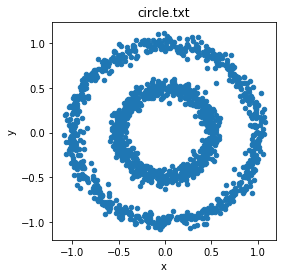

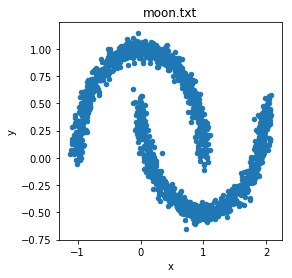

In [3]:
circledf = readData("circle.txt")
moondf = readData("moon.txt")

In [4]:
# 1. Kmeans clustering


def EuclideanDist(data, mean):
    return np.sqrt(np.power((data[:, 0] - mean[:, 0]), 2) + np.power((data[:, 1] - mean[:, 1]), 2))


def Kmeans(data, cluster=2):
    def Estep(data, mu):
        dist = []
        for mean in mu:
            vector_mean = np.tile(mean, len(data)).reshape((len(data), 2))
            dist.append(EuclideanDist(data, vector_mean))
        label = np.argmin(dist, axis=0)
        return label

    def Mstep(data, label, cluster=2):
        return_mu = []
        for i in range(cluster):
            group = data[label == i]
            sum_rnk = len(group)
            sum_x = np.sum(group[:, 0])
            sum_y = np.sum(group[:, 1])
            new_mu = [sum_x / sum_rnk, sum_y / sum_rnk]
            return_mu.append(new_mu)
        return np.array(return_mu)

    # For drawing procedure
    colors = ["red", "magenta", "green", "yellow", "cyan"]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    plt.ion()
    fig.canvas.draw()

    # 1. Initialize centers mu_k
    mu = np.array([[np.random.rand(), np.random.rand()] for _ in range(cluster)])
    iters = 0

    while True:
        ax.clear()
        if iters >= 100:
            break

        # 2. E step: assign all samples to closest mu_k (using euclidean distance)
        label = Estep(data, mu)
        ax.scatter(data[:, 0], data[:, 1], c=label, cmap=mpt.colors.ListedColormap(colors))
        ax.scatter(mu[:, 0], mu[:, 1], c="black", marker="+", s=300, linewidth=3)
        filename = "step_%d.png" % iters
        plt.title("Iter [%d]" % iters)
        plt.savefig(filename)
        plt.gca()

        # 3. M step: update mean mu_k
        new_mu = Mstep(data, label, cluster)
        if np.sum(EuclideanDist(new_mu, mu)) < 1e-3:
            break
        mu = new_mu

        iters += 1

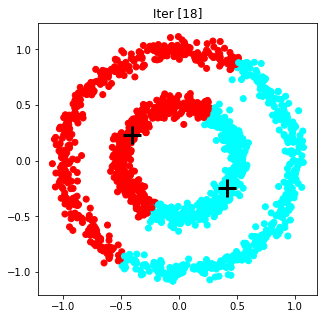

In [5]:
Kmeans(circledf, cluster=2)

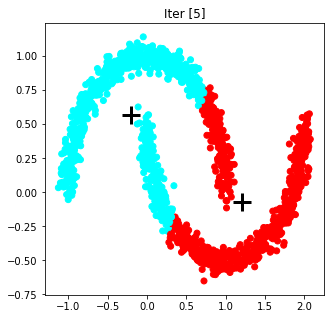

In [6]:
Kmeans(moondf, cluster=2)

In [7]:
# 2. Kernel kmeans


def RBF(x1, x2, gamma=1.0):
    exp_term = (
        np.sum(x1 ** 2, axis=1).reshape(len(x1), 1) - 2 * x1.dot(x2.T) + np.sum(x2 ** 2, axis=1)
    )
    rbf_kernel = -gamma * exp_term
    return np.exp(rbf_kernel, rbf_kernel)


def KernelKMeans(data, cluster=2, gamma=1.0, isSpectral=False, original_data=None):
    def Mstep(cluster_indicator, gram):
        Ck = np.sum(cluster_indicator, axis=0)
        term1 = np.dot(gram * np.eye(len(data)), np.ones((len(data), cluster)))
        term2 = gram.dot(cluster_indicator)
        term3 = np.dot(
            np.ones((len(data), cluster)),
            cluster_indicator.T.dot(gram).dot(cluster_indicator) * np.eye(cluster),
        )
        decision = np.argmin(term1 - 2 / Ck * term2 + 1 / (Ck ** 2) * term3, axis=1)
        update_indicator = np.zeros((len(data), cluster))
        for k in range(cluster):
            update_indicator[decision == k, k] += 1
        return update_indicator

    colors = ["red", "magenta", "green", "yellow", "cyan"]
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    plt.ion()
    fig.canvas.draw()

    # init
    indicator = np.random.randint(0, cluster, size=len(data))
    cluster_indicator = np.zeros((len(data), cluster))
    for k in range(cluster):
        cluster_indicator[indicator == k, k] += 1
    gram = RBF(data, data, gamma)
    iters = 0

    while True:
        ax.clear()
        if iters >= 50:
            break

        # E step
        decision = cluster_indicator.argmax(axis=1)
        if isSpectral:
            ax.scatter(
                original_data[:, 0],
                original_data[:, 1],
                c=decision,
                cmap=mpt.colors.ListedColormap(colors),
            )
        else:
            ax.scatter(data[:, 0], data[:, 1], c=decision, cmap=mpt.colors.ListedColormap(colors))
        # plot center
        center = []
        original_center = []
        for k in range(cluster):
            if isSpectral:
                original_center.append(
                    [
                        np.mean(original_data[decision == k, 0]),
                        np.mean(original_data[decision == k, 1]),
                    ]
                )
            center.append([np.mean(data[decision == k, 0]), np.mean(data[decision == k, 1])])
        center = np.array(center)
        original_center = np.array(original_center)
        if isSpectral:
            ax.scatter(
                original_center[:, 0],
                original_center[:, 1],
                c="black",
                marker="+",
                s=300,
                linewidth=3,
            )
        else:
            ax.scatter(center[:, 0], center[:, 1], c="black", marker="+", s=300, linewidth=3)
        filename = "step_%d.png" % iters
        plt.title("Iter [%d]" % iters)
        plt.savefig(filename)
        plt.gca()

        # M step: update indicator vector
        cluster_indicator = Mstep(cluster_indicator, gram)
        update_decision = cluster_indicator.argmax(axis=1)
        update_center = []
        for k in range(cluster):
            update_center.append(
                [np.mean(data[update_decision == k, 0]), np.mean(data[update_decision == k, 1])]
            )
        update_center = np.array(update_center)
        delta = np.sum(EuclideanDist(update_center, center))
        if delta < 1e-4:
            break
        iters += 1
    return update_decision

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

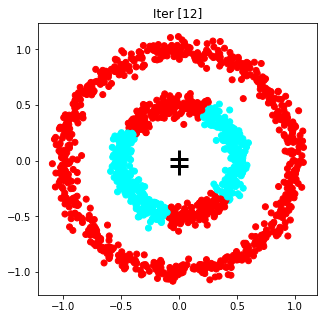

In [8]:
KernelKMeans(circledf, 2, gamma=25)

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

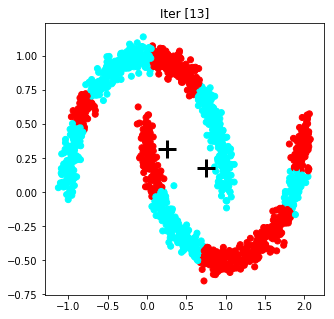

In [9]:
KernelKMeans(moondf, 2, gamma=25)

In [10]:
# 3. Spectral clustering
gamma = 100


def VisualizeSpectral(data, gamma):
    W = RBF(data, data, gamma)
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(221)
    plt.title("Similarity Matrix")
    plt.imshow(W, cmap="gray")
    # Calculate degree
    D = np.sum(W, axis=1) * np.eye(len(W))
    L = D - W
    eigen_val, eigen_vec = np.linalg.eig(L)
    # sort eigen_val and corresponding eigen_vec
    sorted_idx = np.argsort(eigen_val)
    # eigen_vec[:, i] is the ith vector corresponding to eigen_val[i]
    # eigen vector1 is not usable, since this is a fully connected graph
    ax = plt.subplot(222)
    plt.title("Eigen Values")
    plt.xticks([0, 1, 2, 3, 4, 5])
    for i in range(7):
        plt.scatter(i, eigen_val[sorted_idx[i]])

    return eigen_val, eigen_vec

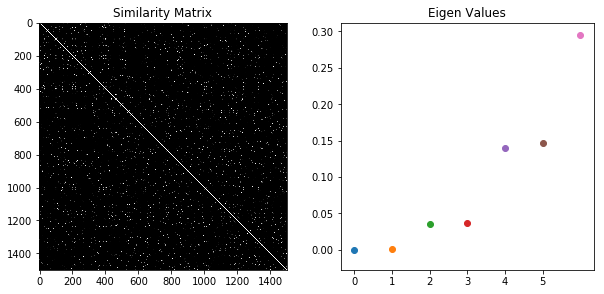

In [11]:
circle_eigen_val, circle_eigen_vec = VisualizeSpectral(circledf, gamma)

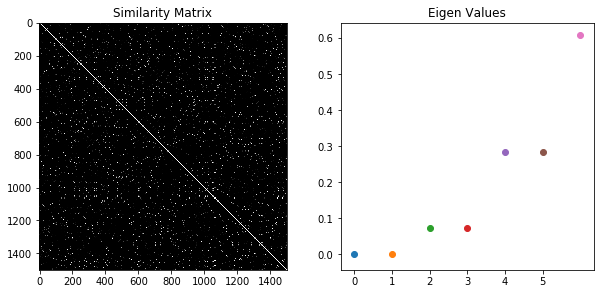

In [12]:
moon_eigen_val, moon_eigen_vec = VisualizeSpectral(moondf, gamma)

In [13]:
# Spectral Clustering
def Spectral(data, eigen_val, eigen_vec, k):
    colors = ["red", "magenta", "green", "yellow", "cyan"]
    U = []
    # Sort eigen value and corresponding eigen vector first
    sort_idx = np.argsort(eigen_val)
    for i in range(1, k + 1):
        U.append(eigen_vec[:, sort_idx[i]])

    # Build U = [e2...ek], for k clusters
    U = np.array(U).T

    # Do kernel-kmeans on U, get predict label
    label = KernelKMeans(U, k, 100, isSpectral=True, original_data=data)

    # Draw clustering result on eigen space
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(121)
    plt.title("In eigenspace")
    plt.scatter(U[:, 0], U[:, 1], c=label, cmap=mpt.colors.ListedColormap(colors))
    # plt.savefig("eigen.png")

    # Draw similarity matrix
    ax = plt.subplot(122)
    plt.title("Similarity Matrix")
    # reorder data
    reordered_data = np.copy(data[label == 0])
    for i in range(1, k):
        reordered_data = np.concatenate((reordered_data, data[label == i]), axis=0)
    plt.imshow(RBF(reordered_data, reordered_data, 100), cmap="gray")
    plt.savefig("simliarity.png")

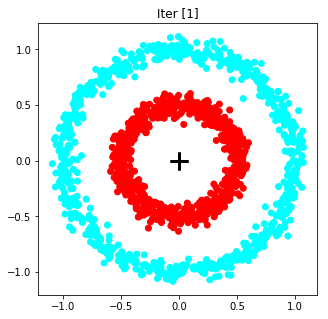

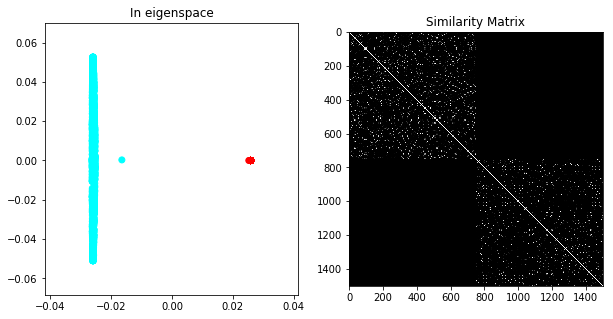

In [14]:
Spectral(circledf, circle_eigen_val, circle_eigen_vec, 2)

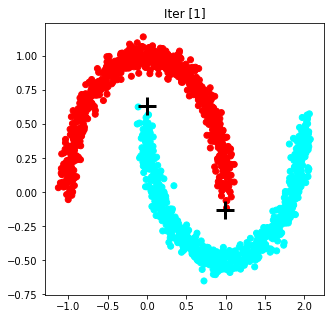

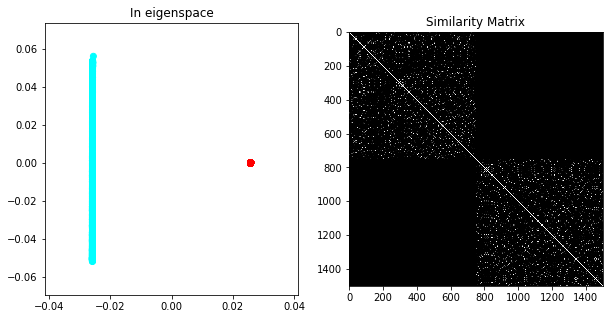

In [15]:
Spectral(moondf, moon_eigen_val, moon_eigen_vec, 2)

In [16]:
def DBSCAN(data, eps, MinPts):
    labels = np.zeros(len(data))
    C = 0
    for point in range(len(data)):
        if labels[point] != 0:
            continue
        N = FindNeighbors(data, point, eps)
        if len(N) < MinPts:
            labels[point] = -1
        else:
            C += 1
            MergeCluster(data, labels, point, N, C, eps, MinPts)

    return labels


def MergeCluster(data, labels, point, neighbors, C, eps, MinPts):
    labels[point] = C
    i = 0
    while i < len(neighbors):
        X_prime = neighbors[i]
        if labels[X_prime] == -1:
            labels[X_prime] = C

        elif labels[X_prime] == 0:
            labels[X_prime] = C

            N_X_prime = FindNeighbors(data, X_prime, eps)
            if len(N_X_prime) >= MinPts:
                neighbors += N_X_prime
        i += 1


def FindNeighbors(data, point, eps):
    def EuDist(a, b):
        return np.sqrt(np.sum((a - b) ** 2))

    neighbors = []
    for i in range(len(data)):
        if EuDist(data[point], data[i]) <= eps:
            neighbors.append(i)
    return neighbors

In [17]:
def VisualizeDBSCAN(data, epsilon, MinPts):
    colors = ["red", "magenta", "green", "yellow", "cyan"]
    label = DBSCAN(data, epsilon, MinPts)
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], c=label, cmap=mpt.colors.ListedColormap(colors))

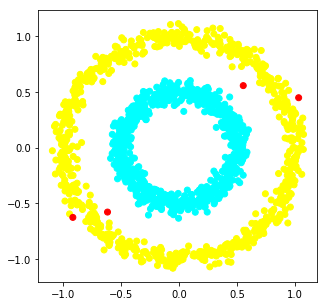

In [18]:
VisualizeDBSCAN(circledf, 0.1, 10)

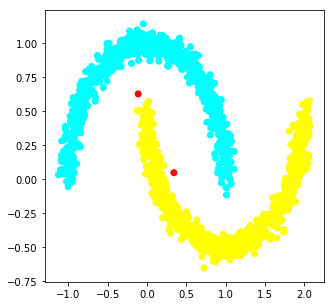

In [19]:
VisualizeDBSCAN(moondf, 0.1, 10)